# Basic script to calibrate the using PMOS
### Purpose:
Contact christopher.arrell@psi.ch

In [1]:
import epics as ep
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
from collections import deque
from scipy.optimize import curve_fit
%matplotlib inline
from IPython.display import clear_output, display
import h5py as h5
from scipy.optimize import curve_fit
import seaborn as sns
from lmfit.models import ConstantModel, GaussianModel, VoigtModel

In /sf/photo/miniconda/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /sf/photo/miniconda/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /sf/photo/miniconda/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


## Setup and functions setup

In [2]:
PMOS_spectrum_name = 'SATOP31-PMOS132-2D:SPECTRUM_Y'
PMOS_e_axis_name = 'SATOP31-PMOS132-2D:SPECTRUM_X'
PMOS_focus_name = 'SLAAT-GSLENS1:SET_CTS_POWER'
MONO_r2_name = 'SATOP11-OSGM087:EXITARM'
PMOS_screen_y_name = 'SATOP31-PMOS132:MOT_Y.VAL'
MONO_status_name = 'SATOP11-OSGM087:STATUS'



PMOS_spectrum_PV = ep.PV(PMOS_spectrum_name)
PMOS_screen_y_PV = ep.PV(PMOS_screen_y_name)
PMOS_e_axis_PV = ep.PV(PMOS_e_axis_name)
PMOS_focus_PV = ep.PV(PMOS_focus_name)
MONO_r2_PV = ep.PV(MONO_r2_name)
MONO_status_PV = ep.PV(MONO_status_name)



PMOS_e_axis = PMOS_e_axis_PV.get()

def set_PMOS_focus(val):
    PMOS_focus_PV.put(val,wait=True)
    sleep(1)
    
def set_PMOS_screen_y(val):
    PMOS_screen_y_PV.put(val,wait=True)
    sleep(1)
    
def set_MONO_r2(val):
    MONO_r2_PV.put(val,wait=True)
    while MONO_status_PV.get() == 1:
        sleep(1)
    

def PMOS_focus_scan(Focus_range, NumShots):
        
    Spectrum_scan = []
    e_axis_scan = []
    
    for focus_val in Focus_range:
        set_PMOS_focus(focus_val)  
           
        Spectrum_this_energy = deque(maxlen = NumShots)
        def on_value_change(value=None,pv = None, **kwargs):
            Spectrum_this_energy.append(value)

            if len(Spectrum_this_energy) == NumShots:
                pv.clear_callbacks()
                
        PMOS_spectrum_PV.add_callback(callback=on_value_change, pv =PMOS_spectrum_PV)
        while len(Spectrum_this_energy) < NumShots:
            sleep(1)
        Spectrum_scan.append(np.array(Spectrum_this_energy))
        e_axis_scan.append(PMOS_e_axis_PV.get())
    return(np.array(e_axis_scan),np.array(Spectrum_scan))

def MONO_r2_scan(r2_range, NumShots):
        
    Spectrum_scan = []
    e_axis_scan = []
    
    for r2 in r2_range:
        set_MONO_r2(r2)  
           
        Spectrum_this_energy = deque(maxlen = NumShots)
        def on_value_change(value=None,pv = None, **kwargs):
            Spectrum_this_energy.append(value)

            if len(Spectrum_this_energy) == NumShots:
                pv.clear_callbacks()
                
        PMOS_spectrum_PV.add_callback(callback=on_value_change, pv =PMOS_spectrum_PV)
        while len(Spectrum_this_energy) < NumShots:
            sleep(1)
        Spectrum_scan.append(np.array(Spectrum_this_energy))
        e_axis_scan.append(PMOS_e_axis_PV.get())
    return(np.array(e_axis_scan),np.array(Spectrum_scan))

def PMOS_screen_y_scan(y_range, NumShots):
        
    Spectrum_scan = []
    e_axis_scan = []
    
    for y in y_range:
        set_PMOS_screen_y(y)  
           
        Spectrum_this_energy = deque(maxlen = NumShots)
        def on_value_change(value=None,pv = None, **kwargs):
            Spectrum_this_energy.append(value)

            if len(Spectrum_this_energy) == NumShots:
                pv.clear_callbacks()
                
        PMOS_spectrum_PV.add_callback(callback=on_value_change, pv =PMOS_spectrum_PV)
        while len(Spectrum_this_energy) < NumShots:
            sleep(1)
        Spectrum_scan.append(np.array(Spectrum_this_energy))
        e_axis_scan.append(PMOS_e_axis_PV.get())
    return(np.array(e_axis_scan),np.array(Spectrum_scan))

def gaus(x,a,x0,sigma,offset):
    return offset +a*np.exp(-(x-x0)**2/(2*sigma**2))

def Spectra_bin(Scan_e_axis, e_axis_full, spectra):
    digi = np.digitize(Scan_e_axis, e_axis_full)   
    Spec_binned = []
    for i in range(0,len(e_axis_full)):
        ind = digi==i+1
        Spec_binned.append(spectra[ind].mean(axis=0))
    return np.asarray(Spec_binned)

def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def bimodal(x, H_1, A_1, x0_1, sigma_1,H_2, A_2, x0_2, sigma_2):
    return gauss(x, H_1, A_1, x0_1, sigma_1)+gauss(x, H_2, A_2, x0_2, sigma_2)

def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

def bimodal_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(bimodal, x, y, p0=[min(y), max(y), mean, sigma,min(y), max(y), mean, sigma])
    return popt

def auto_corr(e_axis, Spec):
    correlations = np.zeros_like(Spec)
    correlations = []
    
    for i in range(0,Spec.shape[0]):
        test = np.correlate(Spec[i,:].astype('float'),Spec[i,:].astype('float'), mode='same')
#         test = np.correlate(Spec[i,:],Spec[i,:], mode='same')
        
        correlations.append(test)
    lags = e_axis - e_axis[int(e_axis.size /2)]
    correlations = np.asarray(correlations)
    return lags, correlations.mean(axis=0)

In [4]:
set_PMOS_screen_y(26)

## User inputs - define focus range to scan 

Scan range

In [78]:
Focus_from = 0.4
Focus_to = 0.6
steps = 20
NumShots= 10
Focus_range = np.linspace(Focus_from, Focus_to, steps)

In [4]:
r2_from = 40
r2_to = 50
steps = 10
NumShots= 100
r2_range = np.linspace(r2_from, r2_to, steps)

In [5]:
y_from = 29
y_to = 36
steps = 10
NumShots= 10
y_range = np.linspace(y_from, y_to, steps)

Only run the follow cell if you want to save in a single energy position



## Scan to calibrate PMOS

In [10]:
set_PMOS_screen_y(y_range[0])
Scan_e_axis, Scan_spec = PMOS_screen_y_scan(y_range,NumShots)

In [11]:
np.argmax(Scan_spec[0,:,:].mean(axis=0))

1471

In [12]:
max_pixel = []
for i in range(0, Scan_spec.shape[0]):
    max_pixel.append(np.argmax(Scan_spec[i,:,:].mean(axis=0)))
    

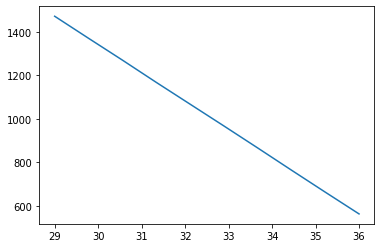

In [13]:
plt.figure()
plt.plot(y_range, max_pixel)

In [14]:
grad = np.abs((max_pixel[0]-max_pixel[-1])/(y_range[0]-y_range[-1]))

In [52]:
78000/800

97.5

In [15]:
fov_mm = Scan_e_axis[0,-1]/grad

In [23]:
calib_const = 19595.2E-3/9400E-3

In [24]:
calib_const

2.084595744680851

In [27]:
#energy_window =0.731*fov_mm
energy_window =(calib_const)*fov_mm

In [28]:
energy_window

33.72126655563114

In [29]:
central_engery = 1020 #eV
energy_0 = central_engery-energy_window/2
energy_1 = central_engery+energy_window/2

In [30]:
e_axis = np.linspace(energy_0, energy_1,Scan_e_axis.shape[1])

In [7]:
e_axis = np.arange(0, 2097)
e_axis = np.arange(0, 2097)

In [31]:
ep.caput('SATOP31-PMOS132-2D:SPECTRUM_X',e_axis)

1

In [24]:
mean_cor = []
for i in range(0, Scan_spec.shape[0]):
    lags, this_cor = auto_corr(Scan_e_axis[0,:], Scan_spec[i,:,:]-50000)
    mean_cor.append(this_cor)
mean_cor = np.asarray(mean_cor)

NameError: name 'Focus_range' is not defined

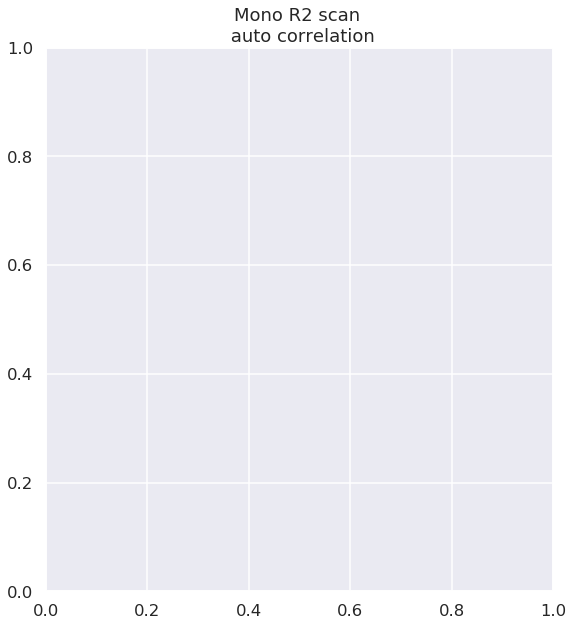

In [25]:
sns.set_style("darkgrid")
sns.set_context("talk")
plt.figure(figsize=[20,10])
plt.subplot(121)
plt.title('Mono R2 scan \n auto correlation')
plt.pcolormesh(lags,Focus_range,mean_cor)
plt.xlabel('lags')
plt.ylabel('Lens voltage')
plt.subplot(122)
index = int(len(Focus_range)/2)
plt.plot(lags, mean_cor[index,:], label = "Len_voltage = %.2f"%Focus_range[index])
plt.legend()
plt.xlabel('lags')

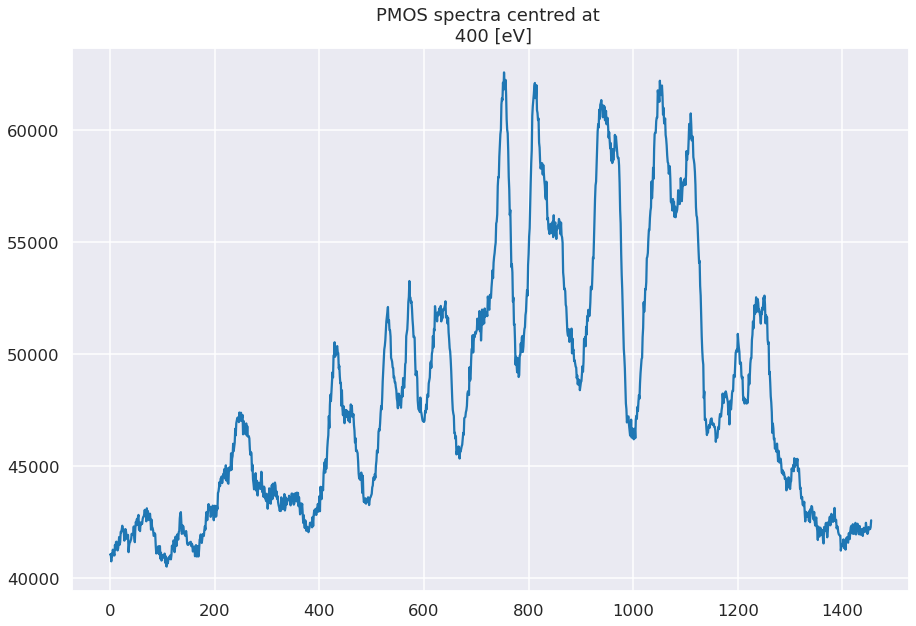

In [99]:
plt.figure(figsize=[15,10])
plt.title('PMOS spectra centred at \n 400 [eV]')
plt.plot(Scan_spec[0,1,:])
# plt.plot(Scan_spec[0,2,:])
plt.savefig('Some_spec', dpi = 300)

In [88]:
Scan_spec.shape

(20, 10, 1456)

In [82]:
# PMOS r2 scan

In [5]:
set_MONO_r2(r2_range[0])
sleep(1)
Scan_e_axis, Scan_spec = MONO_r2_scan(r2_range,NumShots)

In [29]:
Scan_spec_bkg_rm = np.zeros_like(Scan_spec)

In [31]:
for i in range(0,Scan_spec.shape[0]):
    for j in range(0,Scan_spec.shape[1]):
        Scan_spec_bkg_rm[i,j,:] = Scan_spec[i,j,:]-50000

In [69]:
model = GaussianModel(prefix="p1_") + GaussianModel(prefix="p2_") + GaussianModel(prefix="p3_")

model.set_param_hint("p1_center", value=0, vary=False)
model.set_param_hint("p2_center", value=0, vary=False)
model.set_param_hint("p3_center", value=0, vary=False)

In [86]:
peak_width = []
spectral_width = []
bkg_width = []
peak_err = []
spectral_err = []
bkg_err = []
mean_cor =[]
min_width = []
for i in range(0, Scan_spec.shape[0]):
    lags, this_cor = auto_corr(Scan_e_axis[0,:], Scan_spec[i,:,:]-50000)
#     this_cor = np.asarray(this_cor)
    this_cor/= np.max(this_cor)
    lags = lags.astype("float64")
    params = model.make_params()
    result = model.fit(this_cor, params, x=lags, model ='least_squares')

    mean_cor.append(this_cor)
    peak_width.append(result.values['p1_sigma'])
    spectral_width.append(result.values['p2_sigma'])
    bkg_width.append(result.values['p3_sigma'])
    min_width.append(np.min(result.values['p1_sigma'] +result.values['p2_sigma']+result.values['p3_sigma']))

    peak_err.append(result.params['p1_sigma'].stderr)
    spectral_err.append(result.params['p2_sigma'].stderr)
    bkg_err.append(result.params['p3_sigma'].stderr)
mean_cor = np.asarray(mean_cor)

/opt/gfa/python-3.7/2018.12/lib/python3.7/site-packages/lmfit/model.py:969: UserWarning: The keyword argument model does not match any arguments of the model function. It will be ignored.
  "It will be ignored.", UserWarning)
/opt/gfa/python-3.7/2018.12/lib/python3.7/site-packages/lmfit/model.py:969: UserWarning: The keyword argument model does not match any arguments of the model function. It will be ignored.
  "It will be ignored.", UserWarning)
/opt/gfa/python-3.7/2018.12/lib/python3.7/site-packages/lmfit/model.py:969: UserWarning: The keyword argument model does not match any arguments of the model function. It will be ignored.
  "It will be ignored.", UserWarning)
/opt/gfa/python-3.7/2018.12/lib/python3.7/site-packages/lmfit/model.py:969: UserWarning: The keyword argument model does not match any arguments of the model function. It will be ignored.
  "It will be ignored.", UserWarning)
/opt/gfa/python-3.7/2018.12/lib/python3.7/site-packages/lmfit/model.py:969: UserWarning: The key

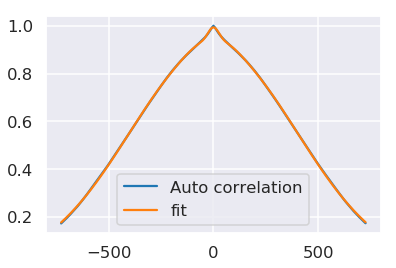

In [80]:
plt.figure()
plt.plot(lags, mean_cor[-1,:], label = 'Auto correlation')
plt.plot(lags, result.best_fit, label ='fit')
plt.legend()

In [98]:
fits = np.zeros(shape = [3,len(r2_range)])
fits[0,:] = peak_width
fits[1,:] = spectral_width
fits[2,:] = bkg_width

In [100]:
fits.shape

(3, 10)

In [101]:
min_width = []
for i in range(0, fits.shape[1]):
    min_width.append(np.min(fits[:,i]))

In [103]:
min_width

[19.459121667809228,
 22.036617592071977,
 19.378019968450552,
 21.27146845341199,
 22.02718201696657,
 26.183195384274672,
 14.962012338122996,
 23.950222138204317,
 28.556110194405207,
 24.17653341065608]

Text(0, 0.5, 'sigma smallest fit')

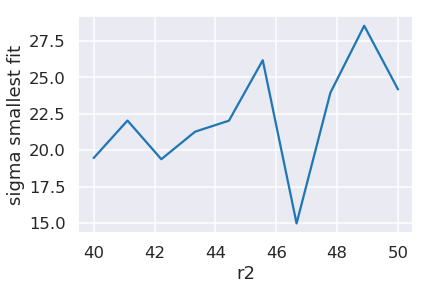

In [106]:
plt.figure()
plt.plot(r2_range, min_width)
plt.xlabel('r2')
plt.ylabel('sigma smallest fit')
# plt.ylim([0, 200])

Text(0.5, 0, 'lags')

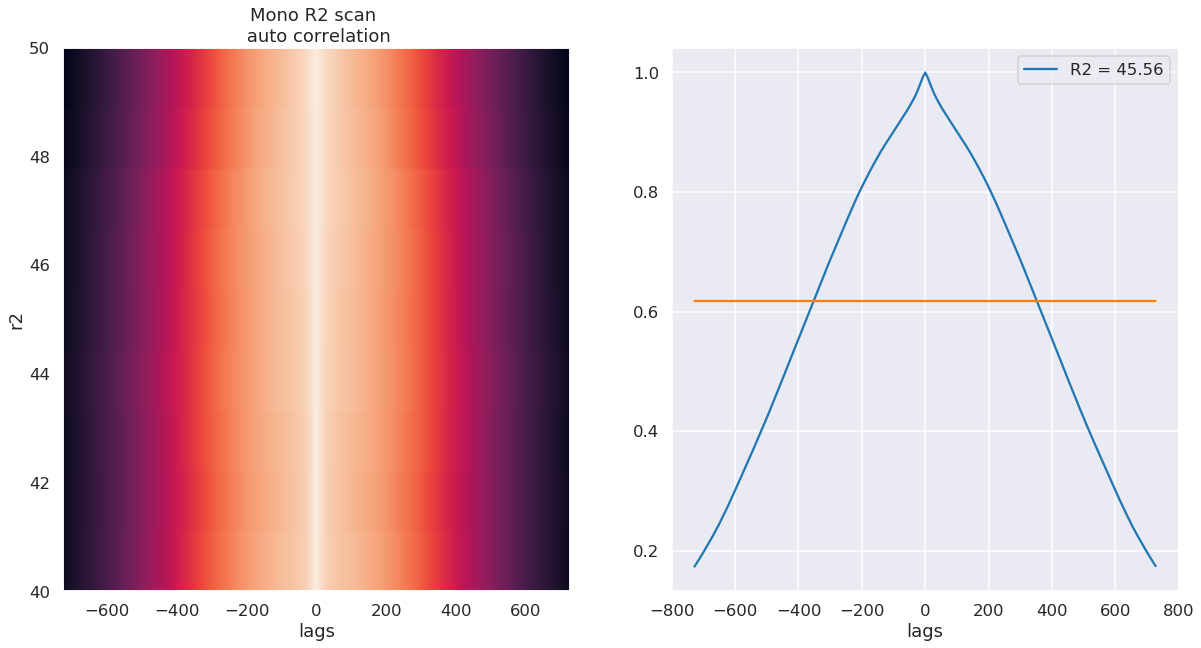

In [61]:
sns.set_style("darkgrid")
sns.set_context("talk")
plt.figure(figsize=[20,10])
plt.subplot(121)
plt.title('Mono R2 scan \n auto correlation')
plt.pcolormesh(lags,r2_range,mean_cor)
plt.xlabel('lags')
plt.ylabel('r2')
plt.subplot(122)
index = int(len(mean_cor)/2)
plt.plot(lags, mean_cor[-1,:], label = "R2 = %.2f"%r2_range[index])
plt.plot(lags, bimodal(lags, *bpopt))
plt.legend()
plt.xlabel('lags')

Text(0, 0.5, 'r2')

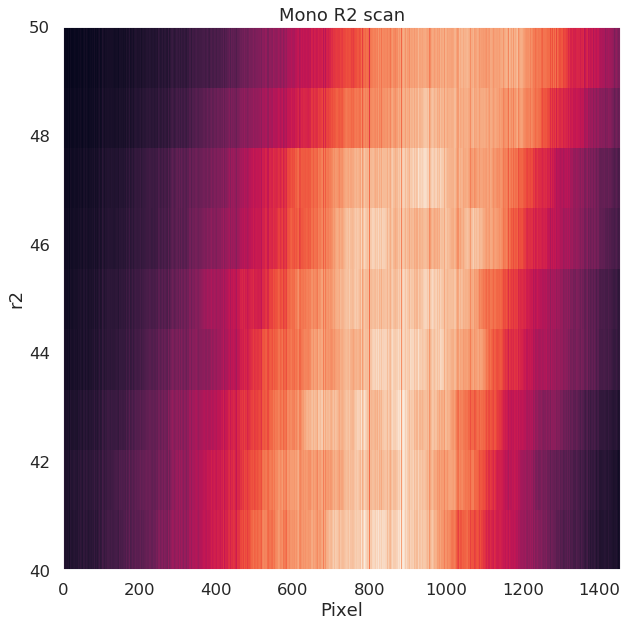

In [8]:
sns.set_style("darkgrid")
sns.set_context("talk")
plt.figure(figsize=[10,10])
plt.title('Mono R2 scan')
plt.pcolormesh(Scan_e_axis.mean(axis=0),r2_range,Scan_spec.mean(axis=1))
plt.xlabel('Pixel')
plt.ylabel('r2')

TypeError: Dimensions of C (5, 2560) are incompatible with X (5) and/or Y (2560); see help(pcolormesh)

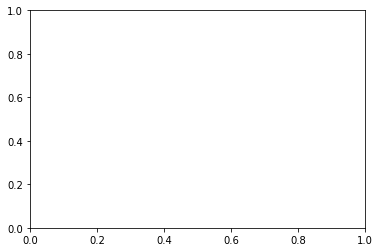

In [19]:
plt.figure()
plt.pcolormesh(Focus_range, Scan_e_axis.mean(axis=0), Scan_spec.mean(axis=1),cmap='CMRmap')


## Save data

In [21]:
folder = "/sf/photo/two_colour_test/"
name = 'energy_scan_100.h5'

In [22]:
with h5.File(folder+name, 'w-') as fh:
    fh['Scan_e_axis'] = Scan_e_axis
    fh['Scan_spec'] = Scan_spec
    fh['Energy_range'] = Energy_range
    fh['e_axis_full'] = e_axis_full
    fh['Bin_spec'] = Bin_spec
    fh['Spec_range'] = Spec_range    